In [2]:
from dataclasses import dataclass
from typing import Dict, Any, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

import sys
sys.path.append("..")
from utils.dataset import ModelData

# General functions

In [5]:
def gen_data_with_outliers(data_size: int, outliers_percent: float):
    """Generate data with outliers."""
    data = np.random.normal(0, 1, int(data_size * (1 - outliers_percent)))
    outliers = np.random.normal(10, 1, int(data_size * outliers_percent))
    return pd.DataFrame({"x": np.concatenate((data, outliers))})


def mark_outlers(data: pd.DataFrame, target_field: str, outlier_field: str):
    median = data[target_field].median()
    zero_data = data[data[outlier_field] == 1]
    zero_data[outlier_field] = 0

    outlier_data = data[data[outlier_field] == -1]
    outlier_data[outlier_field] = outlier_data.apply(
        lambda x: 1 if x[target_field] > median else -1, axis=1
    )
    return pd.concat([zero_data, outlier_data])


def outliers_plot_1d(
    data: pd.DataFrame,
    target_field: str,
    outlier_field: str,
    step=0.001,
    figsize=(15, 10),
):
    """Plot data with outliers, colored by outlier_field."""
    plt.figure(figsize=figsize)
    c_map = {
        -1: "blue",
        0: "black",
        1: "red",
    }
    t_data = pd.DataFrame(
        {
            "x": np.arange(step, 1 + step, step),
        }
    )
    t_data["q"] = t_data["x"].apply(lambda x: np.quantile(data[target_field], x))
    t_data["color"] = t_data["x"].apply(
        lambda x: c_map[
            data.loc[
                (
                    (data[target_field] > data[target_field].quantile(x - step))
                    & (data[target_field] <= data[target_field].quantile(x))
                ),
                outlier_field,
            ].mode()[0]
        ]
    )

    display(t_data)

    plt.scatter(
        t_data["x"],
        t_data["q"],
        c=t_data["color"],
        marker="s",
    )
    plt.title(f"Quantile {target_field} with colors based on {outlier_field}")
    plt.xlabel("Quantile")
    plt.ylabel("Value")
    plt.grid()
    plt.show()

# Outlers filters

In [6]:
@dataclass
class DefaultModelForComparison:
    model_class: type
    default_kwargs: Dict[str, Any]
    tested_parameter_name: str

    def create_model(self, tested_parameter_value: Any):
        return self.model_class(**self.default_kwargs, **{self.tested_parameter_name: tested_parameter_value}) 

def outliers_algorithm_testing(data: ModelData, model):
    key = model.__class__.__name__
    data.data[key] = model.fit_predict(
        data.get_data("train", "features").values.reshape(-1, 1)
    )
    data.data = mark_outlers(data.data, data.features[0], key)
    display(data.data[key].value_counts(normalize=True))
    outliers_plot_1d(data.data, data.features[0], key)

def calc_dot_for_comparison(data: ModelData, model):
    x = data.features[0]
    data.data["dot"] = model.fit_predict(data.get_data("train", "features").values.reshape(-1, 1))
    data.data = mark_outlers(data.data, x, "dot")
    new_data = data.data[data.data["dot"] == 0]
    orig_std = data.data[x].std()
    new_std = new_data[x].std()
    std_reduction = (orig_std - new_std)/orig_std
    return orig_std, new_std, std_reduction

def models_comparison(data: ModelData, models: List[DefaultModelForComparison], tested_parameter_values: List):
    result_table_list = []
    for v in tqdm(tested_parameter_values):
        for model in models:
            m = model.create_model(v)
            orig_std, new_std, std_reduction = calc_dot_for_comparison(data, m)
            result_table_list += [{"model": model.model_class.__name__, "tested_parameter_value": v, "orig_std": orig_std, "new_std": new_std, "std_reduction": std_reduction}]
            # result_table_list += [{"model": model.model_class.__name__, "tested_parameter_value": v, "metric_name": "new_size", "metric_value": new_size}]
    return pd.DataFrame(result_table_list)

def show_models_comparison_resaults(result_table: pd.DataFrame):
    data_groups = dict(list(result_table.groupby("model")))
    sorted_data_groups = {key: value for key, value in sorted(data_groups.items())}
    for key, value in sorted_data_groups.items():
        sv = value.sort_values(by=["tested_parameter_value"])
        plt.plot(sv["tested_parameter_value"], sv["std_reduction"], label=key)
    plt.legend()
    plt.show()

## Gen data

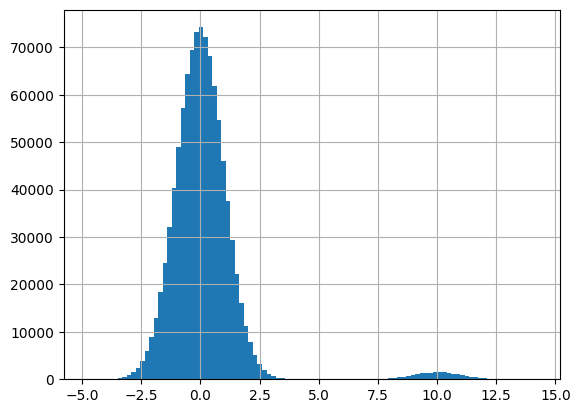

In [7]:
gen_data = gen_data_with_outliers(1_000_000, 0.02)
gen_data.x.hist(bins=100)
data = ModelData(gen_data, "x")

## Isolation Forest

C:\Users\dmatr\AppData\Local\Temp\ipykernel_29420\3983496636.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_data[outlier_field] = 0
C:\Users\dmatr\AppData\Local\Temp\ipykernel_29420\3983496636.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data[outlier_field] = outlier_data.apply(


IsolationForest
0    0.990005
1    0.009995
Name: proportion, dtype: float64

,x,q,color
0,0.001,-3.066569,black
1,0.002,-2.869319,black
2,0.003,-2.744978,black
3,0.004,-2.648892,black
4,0.005,-2.573479,black
...,...,...,...
995,0.996,10.842995,red
996,0.997,11.030584,red
997,0.998,11.274116,red
998,0.999,11.636824,red


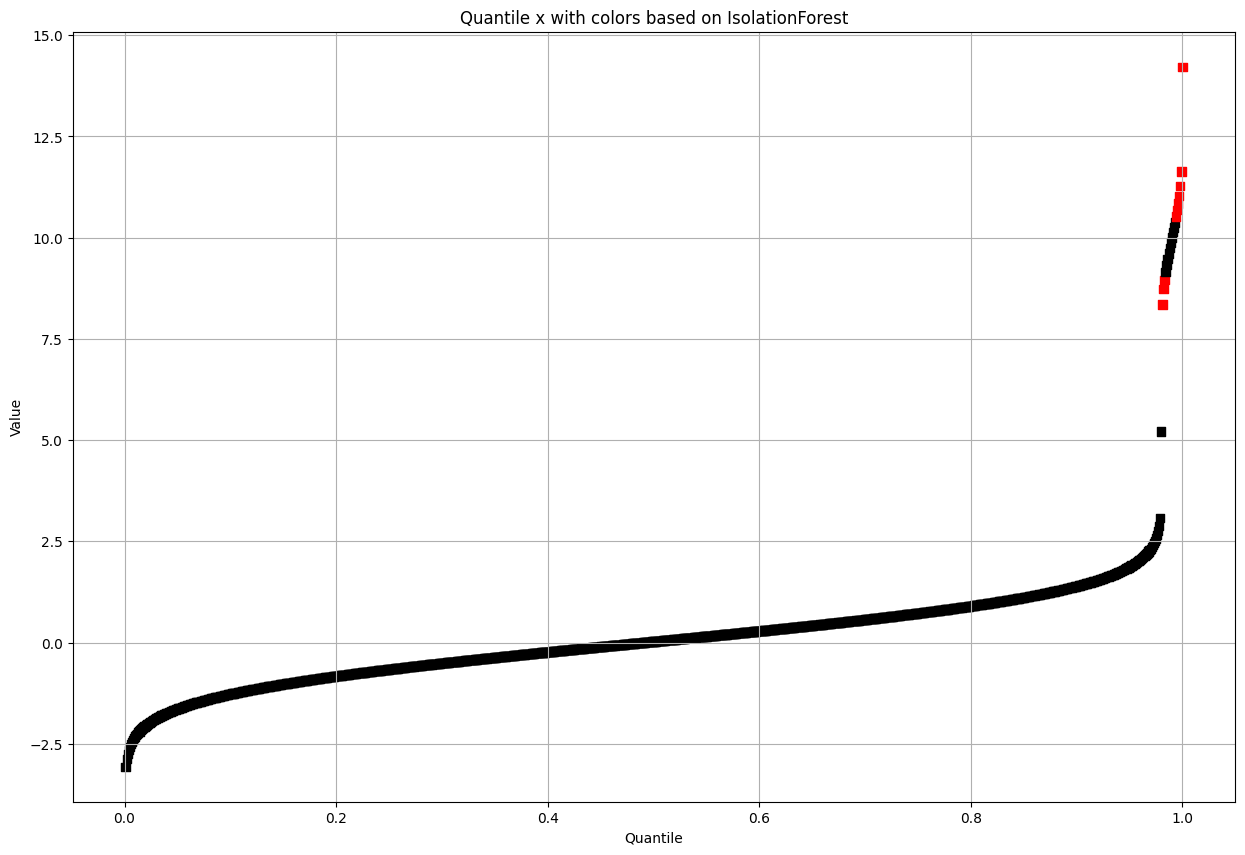

In [8]:
model = IsolationForest(n_estimators=1000, n_jobs=-1, contamination=0.01)
outliers_algorithm_testing(data, model)

## Eleptic Envelope

C:\Users\dmatr\AppData\Local\Temp\ipykernel_29420\3983496636.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_data[outlier_field] = 0
C:\Users\dmatr\AppData\Local\Temp\ipykernel_29420\3983496636.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data[outlier_field] = outlier_data.apply(


EllipticEnvelope
0    0.99
1    0.01
Name: proportion, dtype: float64

,x,q,color
0,0.001,-3.066569,black
1,0.002,-2.869319,black
2,0.003,-2.744978,black
3,0.004,-2.648892,black
4,0.005,-2.573479,black
...,...,...,...
995,0.996,10.842995,red
996,0.997,11.030584,red
997,0.998,11.274116,black
998,0.999,11.636824,black


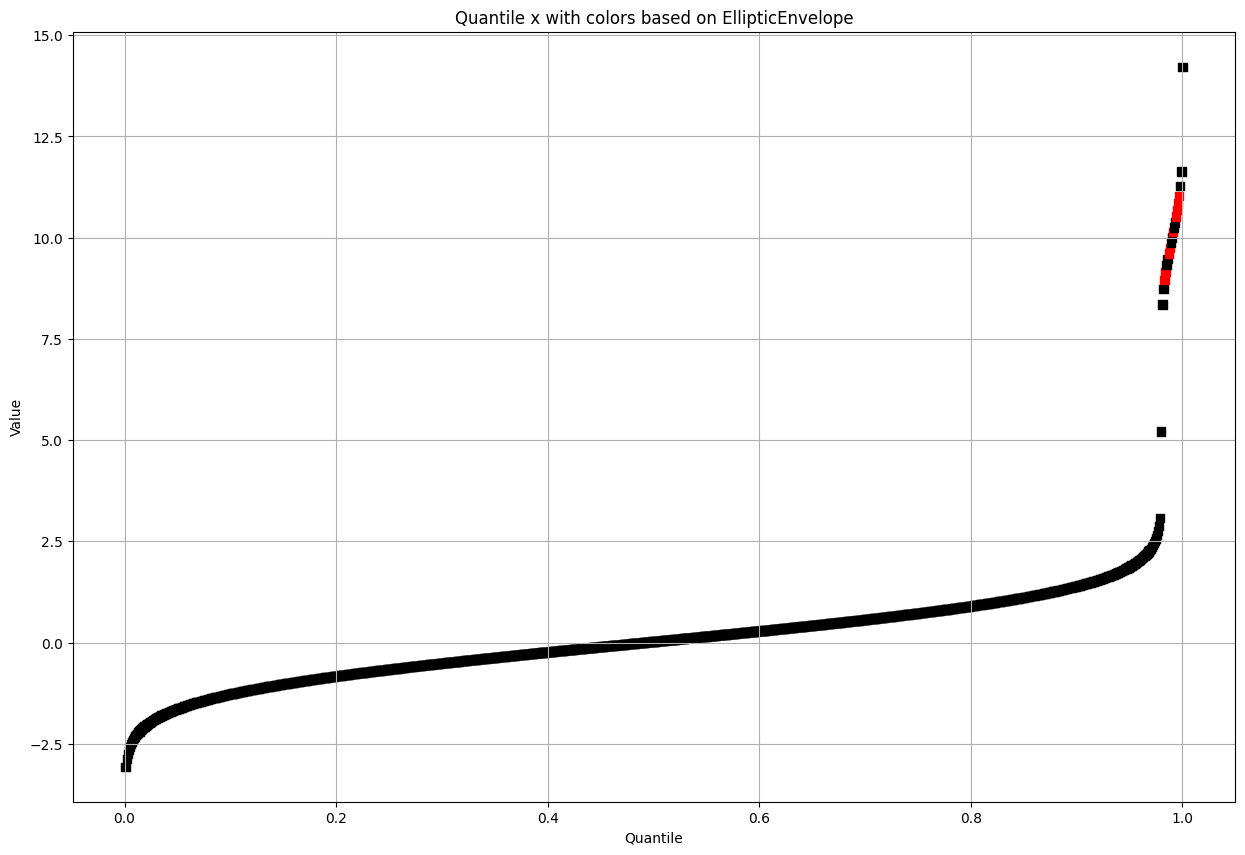

In [9]:
model = EllipticEnvelope(contamination=0.01)
outliers_algorithm_testing(data, model)

## Local Outlier Factor

C:\Users\dmatr\AppData\Local\Temp\ipykernel_29420\3983496636.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_data[outlier_field] = 0
C:\Users\dmatr\AppData\Local\Temp\ipykernel_29420\3983496636.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data[outlier_field] = outlier_data.apply(


LocalOutlierFactor
 0    0.990000
-1    0.005086
 1    0.004914
Name: proportion, dtype: float64

,x,q,color
0,0.001,-3.066569,black
1,0.002,-2.869319,black
2,0.003,-2.744978,black
3,0.004,-2.648892,black
4,0.005,-2.573479,black
...,...,...,...
995,0.996,10.842995,black
996,0.997,11.030584,black
997,0.998,11.274116,black
998,0.999,11.636824,black


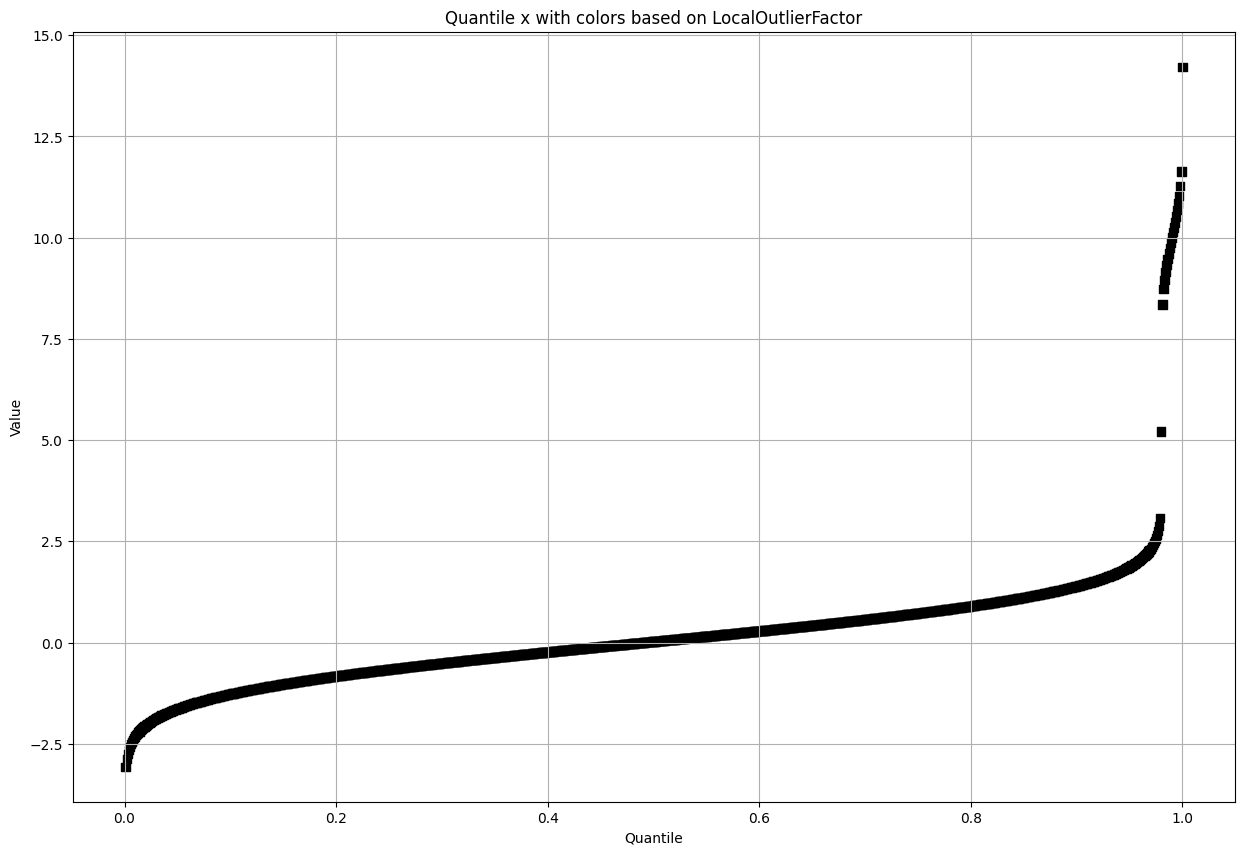

In [10]:
model = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
outliers_algorithm_testing(data, model)

## Compare Algorithms

In [11]:
import warnings

# Mute all warning messages
warnings.filterwarnings("ignore")

  0%|          | 0/39 [00:00<?, ?it/s]

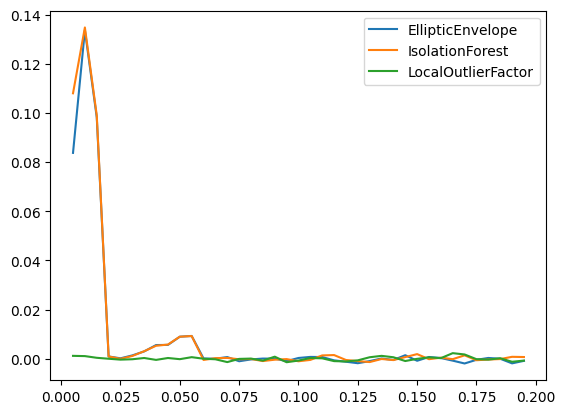

In [12]:
default_models = [
    DefaultModelForComparison(IsolationForest, {'n_estimators': 1000, 'n_jobs': -1}, 'contamination'),
    DefaultModelForComparison(EllipticEnvelope, {}, 'contamination'),
    DefaultModelForComparison(LocalOutlierFactor, {'n_neighbors': 20}, 'contamination'),
]
comparison_table = models_comparison(data, default_models, np.arange(0.005, 0.2, 0.005))
show_models_comparison_resaults(comparison_table)

In [14]:
comparison_table = comparison_table.sort_values("std_reduction", ascending=False)
comparison_table

,model,tested_parameter_value,orig_std,new_std,std_reduction
3,IsolationForest,0.010,1.720812,1.488784,0.134837
4,EllipticEnvelope,0.010,1.720812,1.490638,0.133759
0,IsolationForest,0.005,1.720812,1.534878,0.108050
6,IsolationForest,0.015,1.720812,1.550326,0.099073
7,EllipticEnvelope,0.015,1.720812,1.551658,0.098299
...,...,...,...,...,...
41,LocalOutlierFactor,0.070,1.720812,1.723144,-0.001355
56,LocalOutlierFactor,0.095,1.720812,1.723239,-0.001410
73,EllipticEnvelope,0.125,1.720812,1.723932,-0.001813
112,EllipticEnvelope,0.190,1.720812,1.724032,-0.001871


In [15]:
comparison_table.to_csv("outlier_filter_comparison_table.csv", index=False)

# Permutation Importance

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [3]:
# Example data preparation
df = pd.DataFrame({
    'feature1': np.random.randn(100),
    'feature2': np.random.randn(100),
    'feature3': np.random.randn(100),
    'target': np.random.randn(100)
})

X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Initialize and train the model
model = ExtraTreesRegressor(n_estimators=1000)
model.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=1000)

In [5]:
# Calculate permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Display the feature importances
for i in result.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

feature3: 0.1069 ± 0.1412
feature2: -0.0493 ± 0.1001
feature1: -0.0501 ± 0.1643


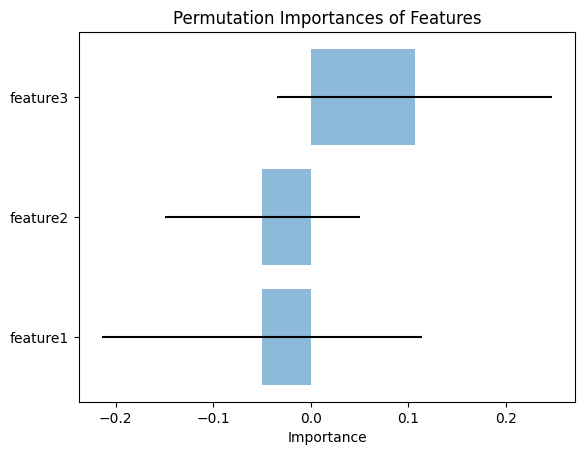

In [9]:
import matplotlib.pyplot as plt

# Plotting the feature importances
plt.barh(X.columns, result.importances_mean, xerr=result.importances_std, align="center", alpha=0.5)
plt.xlabel('Importance')
plt.title('Permutation Importances of Features')
plt.show()